In [1]:
import argparse
import datetime
import json 
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets

import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from models import build_model

def get_args_parser():
    parser = argparse.ArgumentParser('Deformable DETR Detector', add_help=False)
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--lr_backbone_names', default=["backbone.0"], type=str, nargs='+')
    parser.add_argument('--lr_backbone', default=2e-5, type=float)
    parser.add_argument('--lr_linear_proj_names', default=['reference_points', 'sampling_offsets'], type=str, nargs='+')
    parser.add_argument('--lr_linear_proj_mult', default=0.1, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=15, type=int)
    parser.add_argument('--lr_drop', default=5, type=int)
    parser.add_argument('--lr_drop_epochs', default=None, type=int, nargs='+')
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')
    
    parser.add_argument('--num_ref_frames', default=3, type=int, help='number of reference frames')
    parser.add_argument('--num_frames', default=4, type=int, help='number of reference frames')

    parser.add_argument('--sgd', action='store_true')
    parser.add_argument('--gap', default = 2, type = int )
    # Variants of Deformable DETR
    parser.add_argument('--with_box_refine', default=False, action='store_true')
    parser.add_argument('--two_stage', default=False, action='store_true')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    parser.add_argument('--pretrained', default=None, help='resume from checkpoint')
    
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--position_embedding_scale', default=2 * np.pi, type=float,
                        help="position / size * scale")
    parser.add_argument('--num_feature_levels', default=4, type=int, help='number of feature levels')
    parser.add_argument('--checkpoint', default=False, action='store_true')

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=1024, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=300, type=int,
                        help="Number of query slots")
    parser.add_argument('--dec_n_points', default=4, type=int)
    parser.add_argument('--enc_n_points', default=4, type=int)
    parser.add_argument('--n_temporal_decoder_layers', default=1, type=int)
    parser.add_argument('--interval1', default=20, type=int)
    parser.add_argument('--interval2', default=60, type=int)

    parser.add_argument("--fixed_pretrained_model", default=False, action='store_true')
    parser.add_argument("--is_shuffle", default=False, action='store_true')
    
    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")

    # * Matcher
    parser.add_argument('--set_cost_class', default=2, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")

    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--cls_loss_coef', default=2, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--focal_alpha', default=0.25, type=float)

    # dataset parameters
    parser.add_argument('--dataset_file', default='vid_multi')
    parser.add_argument('--coco_path', default='./data/coco', type=str)
    parser.add_argument('--vid_path', default='./data/vid', type=str)
    parser.add_argument('--coco_pretrain', default=False, action='store_true')
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=0, type=int)
    parser.add_argument('--cache_mode', default=False, action='store_true', help='whether to cache images on memory')

    return parser

In [2]:
parser=get_args_parser()
args=parser.parse_args(["--with_box_refine",
                        "--num_frames","12",
                        "--resume", "./exps/multi_model_jet/essai1/checkpoint0006.pth",
                        "--backbone", "swin_b_p4w7",
                        "--num_feature_levels", "1",
                        "--num_queries", "100",
                        "--hidden_dim", "256",
                        "--num_queries", "100",
                        "--dilation",
                        "--batch_size", "1"
                        ])
print(args.num_frames)

12


In [3]:
print("Cuda available:", torch.cuda.is_available(), "Memory allocated :", torch.cuda.max_memory_allocated(), "Device_count: ",torch.cuda.device_count())
print(args.dataset_file, "Start functions importations")
if args.dataset_file == "vid_single":
    from engine_single import evaluate, train_one_epoch
    import util.misc as utils
    
else:
    from engine_multi import evaluate, train_one_epoch
    import util.misc_multi as utils

print(args.dataset_file, "Finished functions importations")
device = torch.device(args.device)
utils.init_distributed_mode(args)
#print("git:\n  {}\n".format(utils.get_sha())) #was making the script bug

if args.frozen_weights is not None:
    assert args.masks, "Frozen training is meant for segmentation only"
print(args)


# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print("Start building model")
model, criterion, postprocessors = build_model(args)
model.to(device)
print("Model complete")

model_without_ddp = model
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

print("Building Datasets")
dataset_train = build_dataset(image_set='train_joint', args=args)
dataset_val = build_dataset(image_set='val', args=args)

if args.distributed:
    if args.cache_mode:
        sampler_train = samplers.NodeDistributedSampler(dataset_train)
        sampler_val = samplers.NodeDistributedSampler(dataset_val, shuffle=False)
    else:
        sampler_train = samplers.DistributedSampler(dataset_train)
        sampler_val = samplers.DistributedSampler(dataset_val, shuffle=False)
else:
    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

print("Starting Dataloader")
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
print("Dataloader finished")
# lr_backbone_names = ["backbone.0", "backbone.neck", "input_proj", "transformer.encoder"]
def match_name_keywords(n, name_keywords):
    out = False
    for b in name_keywords:
        if b in n:
            out = True
            break
    return out

for n, p in model_without_ddp.named_parameters():
    print(n)

param_dicts = [
    {
        "params":
            [p for n, p in model_without_ddp.named_parameters()
                if not match_name_keywords(n, args.lr_backbone_names) and not match_name_keywords(n, args.lr_linear_proj_names) and p.requires_grad],
        "lr": args.lr,
    },
    {
        "params": [p for n, p in model_without_ddp.named_parameters() if match_name_keywords(n, args.lr_backbone_names) and p.requires_grad],
        "lr": args.lr_backbone,
    },
    {
        "params": [p for n, p in model_without_ddp.named_parameters() if match_name_keywords(n, args.lr_linear_proj_names) and p.requires_grad],
        "lr": args.lr * args.lr_linear_proj_mult,
    }
]
if args.sgd:
    optimizer = torch.optim.SGD(param_dicts, lr=args.lr, momentum=0.9,
                                weight_decay=args.weight_decay)
else:
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                    weight_decay=args.weight_decay)
print(args.lr_drop_epochs)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, args.lr_drop_epochs)

if args.distributed:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu], find_unused_parameters=True)
    model_without_ddp = model.module

if args.dataset_file == "coco_panoptic":
    # We also evaluate AP during panoptic training, on original coco DS
    coco_val = datasets.coco.build("val", args)
    base_ds = get_coco_api_from_dataset(coco_val)
else:
    base_ds = get_coco_api_from_dataset(dataset_val)

if args.frozen_weights is not None:
    checkpoint = torch.load(args.frozen_weights, map_location='cpu')
    model_without_ddp.detr.load_state_dict(checkpoint['model'])

output_dir = Path(args.output_dir)
if args.resume:
    if args.resume.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.resume, map_location='cpu')

    if args.eval:
        missing_keys, unexpected_keys = model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
    else:
        tmp_dict = model_without_ddp.state_dict().copy()
        if args.coco_pretrain: # singleBaseline
            for k, v in checkpoint['model'].items():
                if ('class_embed' not in k) :
                    tmp_dict[k] = v 
                else:
                    print('k', k)
        else:
            tmp_dict = checkpoint['model']
            for name, param in model_without_ddp.named_parameters():
                if ('temp' in name):
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        missing_keys, unexpected_keys = model_without_ddp.load_state_dict(tmp_dict, strict=False)

    unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
    if len(missing_keys) > 0:
        print('Missing Keys: {}'.format(missing_keys))
    if len(unexpected_keys) > 0:
        print('Unexpected Keys: {}'.format(unexpected_keys))
if args.eval:
    test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                            data_loader_val, base_ds, device, args.output_dir)
    if args.output_dir:
        utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval.pth")
    
"""
print("Start training")
start_time = time.time()
for epoch in range(args.start_epoch, args.epochs):
    if args.distributed:
        sampler_train.set_epoch(epoch)
    train_stats = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch, args.clip_max_norm)
    lr_scheduler.step()
    print('args.output_dir', args.output_dir)
    if args.output_dir:
        checkpoint_paths = [output_dir / 'checkpoint.pth']
        # extra checkpoint before LR drop and every 5 epochs
        # if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 1 == 0:
        if (epoch + 1) % 1 == 0:
            checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
        for checkpoint_path in checkpoint_paths:
            utils.save_on_master({
                'model': model_without_ddp.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)

    #test_stats, coco_evaluator = evaluate(
        #   model, criterion, postprocessors, data_loader_val, base_ds, device, args.output_dir
    #)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch,
                    'n_parameters': n_parameters}

    if args.output_dir and utils.is_main_process():
        with (output_dir / "log.txt").open("a") as f:
            f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))"""

Cuda available: True Memory allocated : 0 Device_count:  1
vid_multi Start functions importations
vid_multi Finished functions importations
Not using distributed mode
Namespace(lr=0.0002, lr_backbone_names=['backbone.0'], lr_backbone=2e-05, lr_linear_proj_names=['reference_points', 'sampling_offsets'], lr_linear_proj_mult=0.1, batch_size=1, weight_decay=0.0001, epochs=15, lr_drop=5, lr_drop_epochs=None, clip_max_norm=0.1, num_ref_frames=3, num_frames=12, sgd=False, gap=2, with_box_refine=True, two_stage=False, frozen_weights=None, pretrained=None, backbone='swin_b_p4w7', dilation=True, position_embedding='sine', position_embedding_scale=6.283185307179586, num_feature_levels=1, checkpoint=False, enc_layers=6, dec_layers=6, dim_feedforward=1024, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, dec_n_points=4, enc_n_points=4, n_temporal_decoder_layers=1, interval1=20, interval2=60, fixed_pretrained_model=False, is_shuffle=False, masks=False, aux_loss=True, set_cost_class=2, set_cos

c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.num_layers 4


c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model complete
number of params: 106274744
Building Datasets
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Starting Dataloader
Dataloader finished
transformer.level_embed
transformer.encoder.layers.0.self_attn.sampling_offsets.weight
transformer.encoder.layers.0.self_attn.sampling_offsets.bias
transformer.encoder.layers.0.self_attn.attention_weights.weight
transformer.encoder.layers.0.self_attn.attention_weights.bias
transformer.encoder.layers.0.self_attn.value_proj.weight
transformer.encoder.layers.0.self_attn.value_proj.bias
transformer.encoder.layers.0.self_attn.output_proj.weight
transformer.encoder.layers.0.self_attn.output_proj.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layer

'\nprint("Start training")\nstart_time = time.time()\nfor epoch in range(args.start_epoch, args.epochs):\n    if args.distributed:\n        sampler_train.set_epoch(epoch)\n    train_stats = train_one_epoch(\n        model, criterion, data_loader_train, optimizer, device, epoch, args.clip_max_norm)\n    lr_scheduler.step()\n    print(\'args.output_dir\', args.output_dir)\n    if args.output_dir:\n        checkpoint_paths = [output_dir / \'checkpoint.pth\']\n        # extra checkpoint before LR drop and every 5 epochs\n        # if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 1 == 0:\n        if (epoch + 1) % 1 == 0:\n            checkpoint_paths.append(output_dir / f\'checkpoint{epoch:04}.pth\')\n        for checkpoint_path in checkpoint_paths:\n            utils.save_on_master({\n                \'model\': model_without_ddp.state_dict(),\n                \'optimizer\': optimizer.state_dict(),\n                \'lr_scheduler\': lr_scheduler.state_dict(),\n                \'epoch\': 

In [4]:
import matplotlib.pyplot as plt
data_loader_iter = iter(data_loader_train)
images, annotations_1 = next(data_loader_iter)
images= images.tensors

In [5]:
print(annotations_1[0][0])

{'boxes': tensor([[214.7218,  31.5441, 379.0024, 299.1811]]), 'labels': tensor([1]), 'image_id': tensor([23703]), 'area': tensor([43967.5742]), 'iscrowd': tensor([False]), 'orig_size': tensor([617, 617]), 'size': tensor([600, 600])}


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


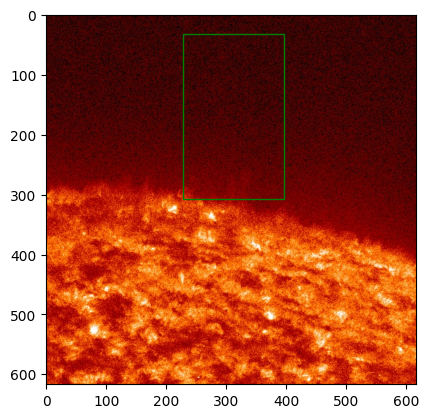

In [6]:
from pycocotools.coco import COCO
from PIL import Image
import os

ann_file = './data/vid/annotations/imagenet_vid_train_joint_30.json'
root="./data/vid/Data"

#create coco class
coco = COCO(ann_file)

img_id=annotations_1[0][0]["image_id"].item()
img_info=coco.loadImgs(img_id)[0]
#print(img_info)
path = img_info['file_name']
video_id = img_info['video_id']
img = Image.open(os.path.join(root, path)).convert('RGB')
ann_ids = coco.getAnnIds(imgIds=img_id)
target=coco.loadAnns(ann_ids)
#print(target) #[227.25915613715452, 32.43783943509516, 168.93523762069057, 275.2200523678612]
target = {'image_id': img_id,'video_id': video_id, 'annotations': target}

#Prepare with ConvertCocoPolysToMask
w, h = img.size

image_id = target["image_id"]
image_id = torch.tensor([image_id])

anno = target["annotations"]

anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

boxes = [obj["bbox"] for obj in anno]

# guard against no boxes via resizing
#IMPORTANT CHANGES FOR BBOXES
boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
boxes[:, 2:] += boxes[:, :2]
boxes[:, 0::2].clamp_(min=0, max=w)
boxes[:, 1::2].clamp_(min=0, max=h)

classes = [obj["category_id"] for obj in anno]
classes = torch.tensor(classes, dtype=torch.int64)

keypoints = None
if anno and "keypoints" in anno[0]:
    keypoints = [obj["keypoints"] for obj in anno]
    keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
    num_keypoints = keypoints.shape[0]
    if num_keypoints:
        keypoints = keypoints.view(num_keypoints, -1, 3)

keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
boxes = boxes[keep]
classes = classes[keep]

if keypoints is not None:
    keypoints = keypoints[keep]

target = {}
target["boxes"] = boxes
target["labels"] = classes
target["image_id"] = image_id
if keypoints is not None:
    target["keypoints"] = keypoints

# for conversion to coco api
area = torch.tensor([obj["area"] for obj in anno])
iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
target["area"] = area[keep]
target["iscrowd"] = iscrowd[keep]

target["orig_size"] = torch.as_tensor([int(h), int(w)])
target["size"] = torch.as_tensor([int(h), int(w)])

plt.imshow(img)
bbox=target["boxes"]



width = bbox[0,2] - bbox[0,0]
height = bbox[0,3] - bbox[0,1]
rect = plt.Rectangle((bbox[0,0], bbox[0,1]), width, height, fill=False, color='green')
plt.gca().add_patch(rect)
plt.show()